In [1]:
import collections
import itertools
import logging
import math
import os
import shelve
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from multiprocessing import Pool

from gensim import corpora, models
from gensim.models import KeyedVectors
from gensim.models import TfidfModel
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics

from nltools.exceptions import WrongExtensionError
from nltools.streams.io_.basic import read_csv
from nltools.streams.preprocessing.basic import preprocess
from nltools.streams.preprocessing.preloading import stop_words
from nltools.streams.preprocessing import w2v

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Предобработка данных

In [3]:
def w2v_preprocess(input_file):
    cur_document = [preprocess(line, stop_words=stop_words, min_len=0) for *_, line in read_csv(f'tg_data/{input_file}', msg_brd=None)]            
    return list(itertools.chain(*cur_document)), [input_file]


def w2v_preprocess_multi(input_files, 
                         batch_size=5, 
                         workers=5,
                         db_name='temp.db',
                         res_var_name='train_corpus'):
    for i in range(0, len(input_files), batch_size):
        print(f'\rPreprocessing files {i}-{i+batch_size}.', end='')
        pool = Pool(processes=workers)
        batch = list(pool.map(w2v_preprocess, input_files[i:i+batch_size]))
        pool.close()
        pool.join()

        with shelve.open(db_name) as db:
            try:
                temp = db[res_var_name]
            except KeyError:
                db[res_var_name] = batch
                continue

            temp += batch
            db[res_var_name] = temp
            del temp, batch

In [4]:
w2v_preprocess_multi(list(os.listdir('tg_data/')), db_name='temp.db', res_var_name='train_corpus')

Preprocessing files 160-165.

# Чтение предобработанных данных

In [2]:
class ShelveReader:
    def __init__(self, filenames, mode='td'):
        self.filenames = filenames
        self.mode = mode
        
    def __iter__(self):
        for fn in self.filenames:
            with shelve.open(fn) as db:
                for doc, label in db[list(db.keys())[0]]:
                    if self.mode == 'td':
                        yield TaggedDocument(doc, label)  
                    elif self.mode == 'asis':
                        yield doc

In [3]:
train_corpus = [doc for doc in ShelveReader(['temp.db'])]

# Doc2Vec
## Создание и обучение модели

In [19]:
%%time
model = Doc2Vec(vector_size=100, dbow_words=1, min_count=2, window=10, sample=1e-3, workers=3, seed=42)
model.build_vocab(train_corpus)

2018-04-15 18:02:20,024 : INFO : collecting all words and their counts
2018-04-15 18:02:20,024 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-04-15 18:02:27,437 : INFO : collected 1288322 word types and 162 unique tags from a corpus of 162 examples and 23058171 words
2018-04-15 18:02:27,438 : INFO : Loading a fresh vocabulary
2018-04-15 18:02:31,458 : INFO : min_count=2 retains 499779 unique words (38% of original 1288322, drops 788543)
2018-04-15 18:02:31,459 : INFO : min_count=2 leaves 22269628 word corpus (96% of original 23058171, drops 788543)
2018-04-15 18:02:32,770 : INFO : deleting the raw counts dictionary of 1288322 items
2018-04-15 18:02:32,802 : INFO : sample=0.001 downsamples 3 most-common words
2018-04-15 18:02:32,802 : INFO : downsampling leaves estimated 21923876 word corpus (98.4% of prior 22269628)
2018-04-15 18:02:34,436 : INFO : estimated required memory for 499779 words and 100 dimensions: 649809900 bytes
2018-04-15 18:02:34,43

CPU times: user 19.3 s, sys: 188 ms, total: 19.5 s
Wall time: 19.5 s


In [20]:
%%time
model.train(train_corpus, 
            total_examples=model.corpus_count, 
            epochs=55)

2018-04-15 18:02:39,374 : INFO : training model with 3 workers on 499779 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
2018-04-15 18:02:40,383 : INFO : EPOCH 1 - PROGRESS: at 28.40% examples, 455183 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:02:41,400 : INFO : EPOCH 1 - PROGRESS: at 62.35% examples, 497244 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:02:42,432 : INFO : EPOCH 1 - PROGRESS: at 95.68% examples, 503878 words/s, in_qsize 4, out_qsize 2
2018-04-15 18:02:42,514 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:02:42,531 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:02:42,568 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:02:42,568 : INFO : EPOCH - 1 : training on 23058171 raw words (1609835 effective words) took 3.2s, 504301 effective words/s
2018-04-15 18:02:43,585 : INFO : EPOCH 2 - PROGRESS: at 32.10% examples, 512689 words/s, in_qsize 

2018-04-15 18:03:15,957 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:03:15,989 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:03:15,990 : INFO : EPOCH - 12 : training on 23058171 raw words (1609830 effective words) took 3.0s, 529596 effective words/s
2018-04-15 18:03:16,999 : INFO : EPOCH 13 - PROGRESS: at 32.72% examples, 524828 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:03:18,006 : INFO : EPOCH 13 - PROGRESS: at 66.05% examples, 529495 words/s, in_qsize 5, out_qsize 0
2018-04-15 18:03:18,953 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:03:18,993 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:03:19,003 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:03:19,004 : INFO : EPOCH - 13 : training on 23058171 raw words (1609841 effective words) took 3.0s, 534470 effective words/s
2018-04-15 18:03:20,057 : INFO : EPOCH 

2018-04-15 18:03:54,010 : INFO : EPOCH 25 - PROGRESS: at 67.90% examples, 540383 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:03:54,907 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:03:54,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:03:54,941 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:03:54,941 : INFO : EPOCH - 25 : training on 23058171 raw words (1609839 effective words) took 3.0s, 543729 effective words/s
2018-04-15 18:03:55,953 : INFO : EPOCH 26 - PROGRESS: at 32.72% examples, 523723 words/s, in_qsize 4, out_qsize 1
2018-04-15 18:03:56,962 : INFO : EPOCH 26 - PROGRESS: at 66.05% examples, 528503 words/s, in_qsize 3, out_qsize 2
2018-04-15 18:03:57,899 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:03:57,917 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:03:57,935 : INFO : worker thread finished; awaitin

2018-04-15 18:04:31,517 : INFO : EPOCH 38 - PROGRESS: at 33.33% examples, 529367 words/s, in_qsize 6, out_qsize 1
2018-04-15 18:04:32,524 : INFO : EPOCH 38 - PROGRESS: at 67.28% examples, 536718 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:04:33,436 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:04:33,441 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:04:33,466 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:04:33,467 : INFO : EPOCH - 38 : training on 23058171 raw words (1609840 effective words) took 3.0s, 542518 effective words/s
2018-04-15 18:04:34,494 : INFO : EPOCH 39 - PROGRESS: at 32.72% examples, 517578 words/s, in_qsize 3, out_qsize 2
2018-04-15 18:04:35,500 : INFO : EPOCH 39 - PROGRESS: at 67.28% examples, 536055 words/s, in_qsize 4, out_qsize 1
2018-04-15 18:04:36,410 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:04:36,424 : INFO : worker t

2018-04-15 18:05:09,801 : INFO : EPOCH 51 - PROGRESS: at 33.33% examples, 532511 words/s, in_qsize 6, out_qsize 0
2018-04-15 18:05:10,858 : INFO : EPOCH 51 - PROGRESS: at 67.90% examples, 530158 words/s, in_qsize 3, out_qsize 2
2018-04-15 18:05:11,739 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:05:11,743 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-04-15 18:05:11,764 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-04-15 18:05:11,764 : INFO : EPOCH - 51 : training on 23058171 raw words (1609841 effective words) took 3.0s, 541154 effective words/s
2018-04-15 18:05:12,814 : INFO : EPOCH 52 - PROGRESS: at 33.95% examples, 523921 words/s, in_qsize 4, out_qsize 1
2018-04-15 18:05:13,814 : INFO : EPOCH 52 - PROGRESS: at 67.90% examples, 535677 words/s, in_qsize 5, out_qsize 0
2018-04-15 18:05:14,683 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-04-15 18:05:14,712 : INFO : worker t

CPU times: user 7min 41s, sys: 1.08 s, total: 7min 42s
Wall time: 2min 44s


## Проверка на вменяемость для Doc2Vec модели 

In [9]:
def get_ranks(train_corpus):
    ranks = []

    for doc in train_corpus:
        inferred_vector = model.infer_vector(doc.words)
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        rank = [docid for docid, sim in sims].index(doc.tags[0])
        ranks.append(rank)
    
    return collections.Counter(ranks)

In [10]:
%%time
get_ranks(train_corpus)

2018-04-15 17:40:01,299 : INFO : precomputing L2-norms of doc weight vectors


CPU times: user 1min 9s, sys: 2.04 s, total: 1min 11s
Wall time: 41.9 s


Counter({0: 162})

In [11]:
model.save('d2v-215')

2018-04-15 17:40:43,118 : INFO : saving Doc2Vec object under d2v-215, separately None
2018-04-15 17:40:43,120 : INFO : storing np array 'syn1neg' to d2v-215.trainables.syn1neg.npy
2018-04-15 17:40:44,394 : INFO : storing np array 'vectors' to d2v-215.wv.vectors.npy
2018-04-15 17:40:48,151 : INFO : saved d2v-215


In [41]:
del model

## Проверка результатов векторизации путем проведения кластеризации и отрисовки векторов в сжатом пространстве

In [14]:
true_labels_df = pd.read_csv('ds_true.csv')
true_labels = [j-1 for i in range(len(true_labels_df)) for j, el in enumerate(true_labels_df.iloc[i]) if el == 1]

In [3]:
model = Doc2Vec.load('vs52mc2ephs55')

2018-04-09 18:55:34,098 : INFO : loading Doc2Vec object from vs52mc2ephs55
2018-04-09 18:55:36,054 : INFO : loading vocabulary recursively from vs52mc2ephs55.vocabulary.* with mmap=None
2018-04-09 18:55:36,055 : INFO : loading trainables recursively from vs52mc2ephs55.trainables.* with mmap=None
2018-04-09 18:55:36,055 : INFO : loading syn1neg from vs52mc2ephs55.trainables.syn1neg.npy with mmap=None
2018-04-09 18:55:36,128 : INFO : loading wv recursively from vs52mc2ephs55.wv.* with mmap=None
2018-04-09 18:55:36,129 : INFO : loading vectors from vs52mc2ephs55.wv.vectors.npy with mmap=None
2018-04-09 18:55:36,203 : INFO : loading docvecs recursively from vs52mc2ephs55.docvecs.* with mmap=None
2018-04-09 18:55:36,204 : INFO : loaded vs52mc2ephs55


In [21]:
doc_vectors = []

for fname in true_labels_df['dump_id']:
    doc_vectors.append(model.docvecs[fname].reshape(-1, 1))

In [22]:
kmeans = KMeans(n_clusters=8, random_state=42)
pred_labels = kmeans.fit_predict(model.docvecs.vectors_docs)

In [23]:
metrics.fowlkes_mallows_score(true_labels, pred_labels)  

0.14492549648101863

model = Doc2Vec(vector_size=50, min_count=2, sample=1e-5, workers=4) -- 0.14086823960956465

model = Doc2Vec(vector_size=400, min_count=2, window=6, sample=1e-5, workers=4) -- 0.14888268334614022

model = Doc2Vec(vector_size=400, min_count=2, window=6, sample=1e-6, workers=4) -- 0.18628878806361712

model = Doc2Vec(vector_size=400, min_count=2, window=3, sample=1e-6, workers=4) -- 0.177933197245823

model = Doc2Vec(vector_size=400, min_count=2, window=10, sample=1e-6, workers=4) -- 0.21118463712915594

model = Doc2Vec(vector_size=400, min_count=2, window=10, sample=1e-7, workers=4) -- 0.15144894062234954

model = Doc2Vec(vector_size=400, dm=0, min_count=2, window=10, sample=1e-6, workers=4) -- 0.1635102868186538

model = Doc2Vec(vector_size=400, dbow_words=1, min_count=2, window=10, sample=1e-6, workers=4) -- 0.21547558866834945

model = Doc2Vec(vector_size=400, negative=10, dbow_words=1, min_count=1, window=10, sample=1e-6, workers=4) -- 0.13814767369837347

### Отрисовка векторов (PCA)

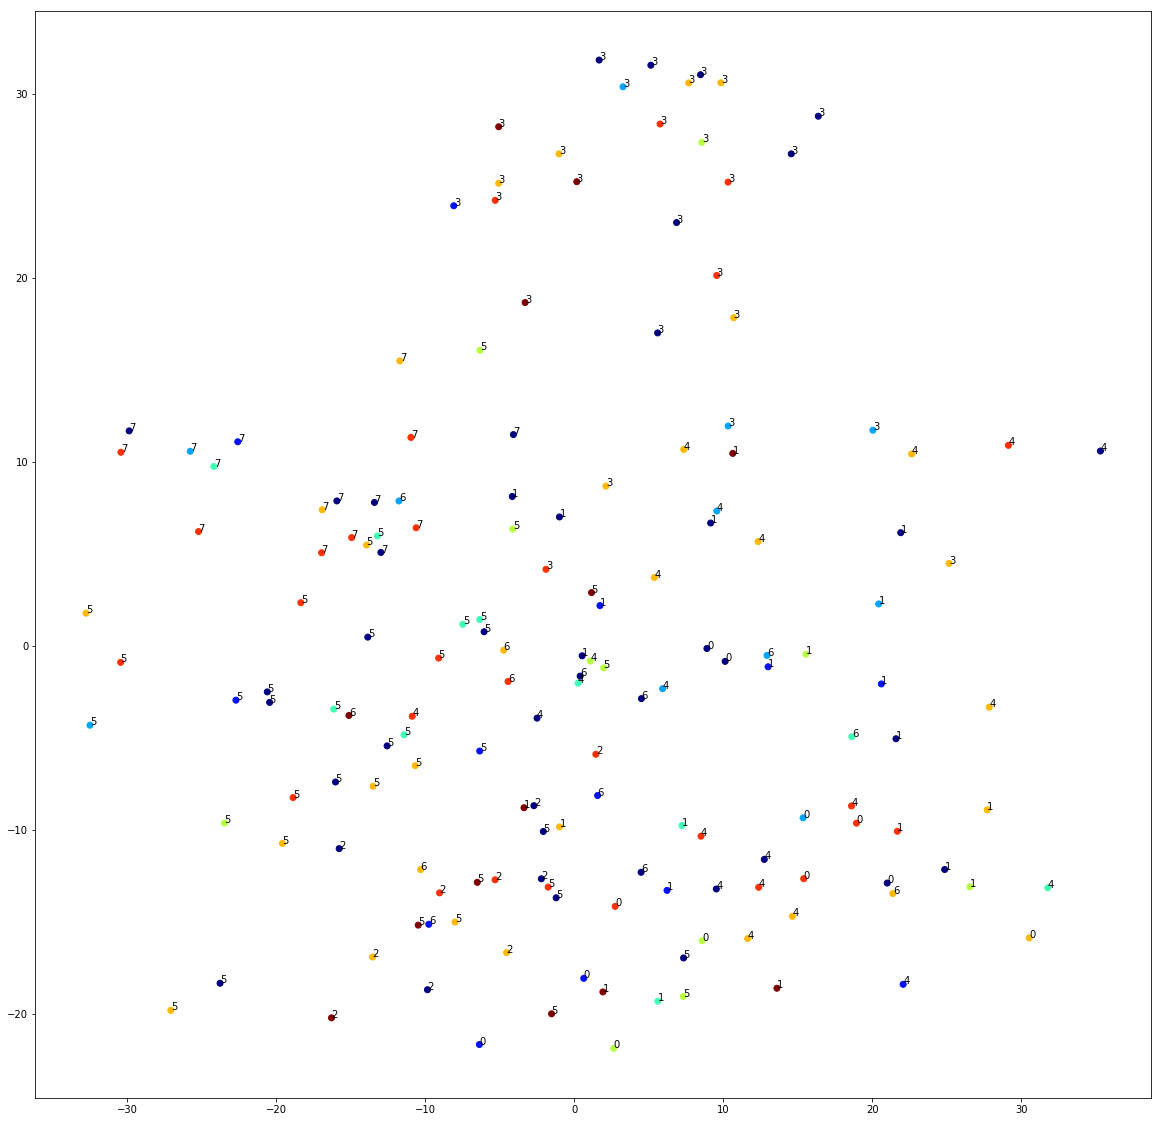

In [24]:
pca = PCA(n_components=2)
X = pca.fit_transform(model.docvecs.vectors_docs)

plt.figure(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

### Отрисовка векторов (TSNE)

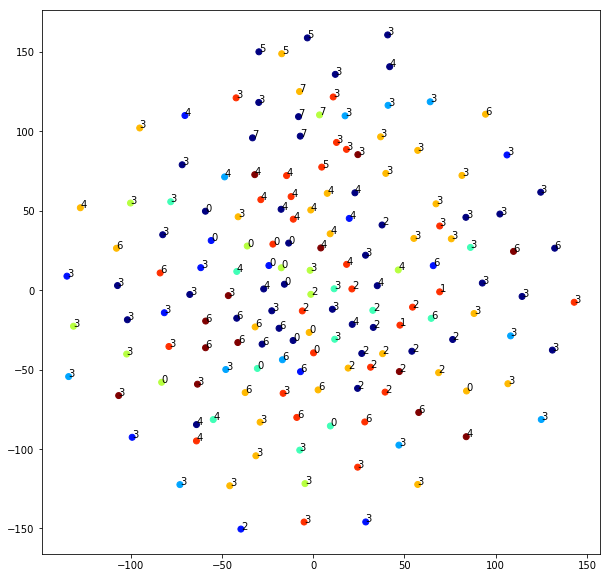

In [11]:
X = TSNE(n_components=2).fit_transform(model.docvecs.vectors_docs)

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='jet')

for label, x, y in zip(pred_labels, X[:, 0], X[:, 1]):
    plt.annotate(label, xy=(x, y))

plt.show()

In [18]:
del model, X, train_corpus, true_labels

# Тематическое моделирование

In [19]:
train_corpus = [doc for doc in ShelveReader(['temp.db'], mode='asis')]

In [20]:
dct = corpora.Dictionary(train_corpus)

2018-04-15 17:41:05,913 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-15 17:41:31,356 : INFO : built Dictionary(1288322 unique tokens: ['0', '00', '000', '01', '0100084726']...) from 162 documents (total 23058171 corpus positions)


In [21]:
corpus = [dct.doc2bow(line) for line in train_corpus]

In [22]:
tfidf = TfidfModel(corpus)

2018-04-15 17:41:47,836 : INFO : collecting document frequencies
2018-04-15 17:41:47,837 : INFO : PROGRESS: processing document #0
2018-04-15 17:41:49,346 : INFO : calculating IDF weights for 162 documents and 1288321 features (5357529 matrix non-zeros)


In [23]:
corpus_tfidf = tfidf[corpus]

In [24]:
lsi = models.LsiModel(corpus_tfidf, id2word=dct, num_topics=8)

2018-04-15 17:41:52,132 : INFO : using serial LSI version on this node
2018-04-15 17:41:52,132 : INFO : updating model with new documents
2018-04-15 17:42:14,681 : INFO : preparing a new chunk of documents
2018-04-15 17:42:16,207 : INFO : using 100 extra samples and 2 power iterations
2018-04-15 17:42:16,208 : INFO : 1st phase: constructing (1288322, 108) action matrix
2018-04-15 17:42:17,825 : INFO : orthonormalizing (1288322, 108) action matrix
2018-04-15 17:42:59,115 : INFO : 2nd phase: running dense svd on (108, 162) matrix
2018-04-15 17:42:59,811 : INFO : computing the final decomposition
2018-04-15 17:42:59,812 : INFO : keeping 8 factors (discarding 79.398% of energy spectrum)
2018-04-15 17:43:00,175 : INFO : processed documents up to #162
2018-04-15 17:43:00,617 : INFO : topic #0(2.824): 0.061*"биток" + 0.060*"фильм" + 0.055*"тян" + 0.052*"нахуй" + 0.051*"блять" + 0.050*"нихуя" + 0.050*"ебать" + 0.049*"пиздец" + 0.046*"хуй" + 0.046*"кино"
2018-04-15 17:43:00,643 : INFO : topic #

In [25]:
lsi.print_topics(8)

2018-04-15 17:43:01,013 : INFO : topic #0(2.824): 0.061*"биток" + 0.060*"фильм" + 0.055*"тян" + 0.052*"нахуй" + 0.051*"блять" + 0.050*"нихуя" + 0.050*"ебать" + 0.049*"пиздец" + 0.046*"хуй" + 0.046*"кино"
2018-04-15 17:43:01,039 : INFO : topic #1(1.772): -0.216*"гимы" + 0.186*"биток" + -0.184*"покемонов" + -0.174*"поков" + -0.165*"гим" + -0.146*"покемона" + -0.142*"гимов" + -0.111*"снорлакс" + -0.110*"люры" + -0.108*"блисси"
2018-04-15 17:43:01,069 : INFO : topic #2(1.734): -0.292*"биток" + -0.152*"рипл" + -0.151*"гимы" + -0.130*"битка" + -0.125*"покемонов" + -0.122*"поков" + -0.117*"btc" + -0.115*"гим" + -0.107*"эфир" + -0.103*"покемона"
2018-04-15 17:43:01,095 : INFO : topic #3(1.726): 0.125*"биток" + -0.121*"js" + -0.106*"реакт" + -0.098*"npm" + -0.082*"import" + -0.079*"докер" + -0.078*"жс" + 0.072*"фильм" + -0.072*"юнити" + -0.067*"json"
2018-04-15 17:43:01,130 : INFO : topic #4(1.485): 0.157*"пс4" + 0.103*"3дс" + 0.092*"ханзо" + 0.091*"длц" + 0.090*"пс3" + 0.089*"биток" + 0.088*"и

[(0,
  '0.061*"биток" + 0.060*"фильм" + 0.055*"тян" + 0.052*"нахуй" + 0.051*"блять" + 0.050*"нихуя" + 0.050*"ебать" + 0.049*"пиздец" + 0.046*"хуй" + 0.046*"кино"'),
 (1,
  '-0.216*"гимы" + 0.186*"биток" + -0.184*"покемонов" + -0.174*"поков" + -0.165*"гим" + -0.146*"покемона" + -0.142*"гимов" + -0.111*"снорлакс" + -0.110*"люры" + -0.108*"блисси"'),
 (2,
  '-0.292*"биток" + -0.152*"рипл" + -0.151*"гимы" + -0.130*"битка" + -0.125*"покемонов" + -0.122*"поков" + -0.117*"btc" + -0.115*"гим" + -0.107*"эфир" + -0.103*"покемона"'),
 (3,
  '0.125*"биток" + -0.121*"js" + -0.106*"реакт" + -0.098*"npm" + -0.082*"import" + -0.079*"докер" + -0.078*"жс" + 0.072*"фильм" + -0.072*"юнити" + -0.067*"json"'),
 (4,
  '0.157*"пс4" + 0.103*"3дс" + 0.092*"ханзо" + 0.091*"длц" + 0.090*"пс3" + 0.089*"биток" + 0.088*"ивус" + 0.087*"псн" + 0.085*"киря" + 0.082*"вии"'),
 (5,
  '0.256*"фильм" + 0.178*"кино" + 0.139*"смотрела" + 0.118*"фильма" + 0.102*"фугу" + 0.096*"фильмы" + 0.093*"фильмов" + 0.089*"трейлер" + 0.08

In [ ]:
# test_cluster = [i for i in range(len(labels)) if labels[i] == 2]

# # for i in test_cluster:
# #     print(f'i:{i} {vld.iloc[i]["IT"]}')
# for i in range(43):
#     print(f'{labels[i]}')
# collections.Counter(labels)